<a href="https://colab.research.google.com/github/mshilpaa/EVA4/blob/master/Session%206/l1_0.00005%20l2_0.05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


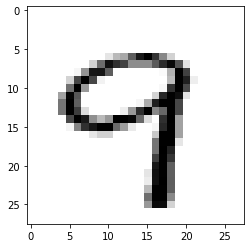

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

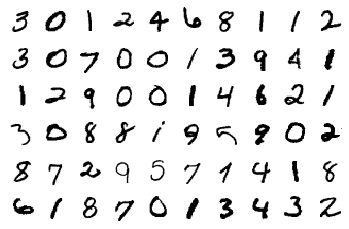

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), # i/p= 28 o/p=26 r=3
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # i/p=26  o/p=24 r=5
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(p=0.05),
            
            nn.MaxPool2d(kernel_size=(2,2)), # i/p=24  o/p=12 r=6  

            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=12  o/p=10 r=10
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),
            

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=10  o/p=8 r=14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=8  o/p=6 r=18
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=6  o/p=4 r=22
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # i/p=4  o/p=2 r=26
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(p=0.05),

            nn.AdaptiveAvgPool2d(1),

            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),


        ) 

    def forward(self, x):

        x = self.convblock1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
              ReLU-6           [-1, 10, 24, 24]               0
       BatchNorm2d-7           [-1, 10, 24, 24]              20
           Dropout-8           [-1, 10, 24, 24]               0
         MaxPool2d-9           [-1, 10, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,080
             ReLU-11           [-1, 12, 10, 10]               0
      BatchNorm2d-12           [-1, 12, 10, 10]              24
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
def L1_loss(model, data, factor):
  l1_crit = nn.L1Loss().to(device)
  reg_loss = 0
  for param in model.parameters():
    zero_vector = torch.rand_like(param) * 0
    reg_loss += l1_crit(param, zero_vector)
  return factor * reg_loss

In [0]:
def misclassified_images(misclassify):
  j=0
  fig = plt.figure(figsize=(15,15)) 
  for i in range(25): 
      ax = fig.add_subplot(5,5 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
      plt.imshow(misclassify[i][0].cpu().numpy().squeeze(), cmap='gray_r') # display the image
      title = "Predicted: "+ str(misclassify[i][1][0].data.cpu().numpy())+" Target: "+ str(misclassify[i][2].data.cpu().numpy())
      ax.set_title(title) # give the class of the image as its title
      j+=1
  plt.subplots_adjust( hspace=0.5, wspace=0.35)      
  plt.show()

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassify = []

def train(model, device, train_loader, optimizer, epoch, use_l1 = False,l1_factor = 0.0005):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    if use_l1 == True:
      loss += L1_loss(model,data,factor=l1_factor)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # output is the probability for each class
            
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            for i in range(len(pred)):
              if pred[i] != target[i]:
                misclassify.append([data[i],pred[i],target[i]])
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    # print("o === ",pred,"-------target = ",target,"output",output.shape)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # print(len(misclassify))
    # print(misclassify[0][0].size()) 
    test_acc.append(100. * correct / len(test_loader.dataset))

    # j=0
    # fig = plt.figure(figsize=(15,15)) 
    # for i in range(25): 
    #     ax = fig.add_subplot(7,4 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
    #     plt.imshow(misclassify[i][0].cpu().numpy().squeeze(), cmap='gray_r') # display the image
    #     title = "predicted: "+ str(misclassify[i][1].data.cpu().numpy())+"target: "+ str(misclassify[i][2].data.cpu().numpy())
    #     ax.set_title(title) # give the class of the image as its title
    #     j+=1      
    # plt.show()

# Let's Train and test our model

In [0]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.13958649337291718 Batch_id=468 Accuracy=91.36: 100%|██████████| 469/469 [00:13<00:00, 35.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9835/10000 (98.35%)

EPOCH: 1 lr =  0.01


Loss=0.1301785260438919 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:13<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9866/10000 (98.66%)

EPOCH: 2 lr =  0.01


Loss=0.03403477370738983 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9888/10000 (98.88%)

EPOCH: 3 lr =  0.01


Loss=0.02134089730679989 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9917/10000 (99.17%)

EPOCH: 4 lr =  0.01


Loss=0.04528331384062767 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:13<00:00, 34.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.11%)

EPOCH: 5 lr =  0.01


Loss=0.017364243045449257 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 34.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9910/10000 (99.10%)

EPOCH: 6 lr =  0.001


Loss=0.011242985725402832 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 7 lr =  0.001


Loss=0.008119314908981323 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 8 lr =  0.0001


Loss=0.0070090144872665405 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9937/10000 (99.37%)

EPOCH: 9 lr =  0.0001


Loss=0.003089040517807007 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

EPOCH: 10 lr =  0.0001


Loss=0.08355611562728882 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 11 lr =  0.0001


Loss=0.01227154303342104 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 12 lr =  1e-05


Loss=0.050826702266931534 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 34.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9934/10000 (99.34%)

EPOCH: 13 lr =  1e-05


Loss=0.006768524646759033 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 43.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH: 14 lr =  1e-05


Loss=0.0044428459368646145 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 35.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9936/10000 (99.36%)

EPOCH: 15 lr =  1e-05


Loss=0.0043668546713888645 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 16 lr =  1e-05


Loss=0.03981681540608406 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9938/10000 (99.38%)

EPOCH: 17 lr =  1e-05


Loss=0.008420323021709919 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 35.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 18 lr =  1e-05


Loss=0.03642800822854042 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

EPOCH: 19 lr =  1e-05


Loss=0.07358149439096451 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:13<00:00, 34.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

EPOCH: 20 lr =  1e-05


Loss=0.0645044818520546 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 35.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 21 lr =  1e-05


Loss=0.01353714894503355 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 36.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 22 lr =  1e-05


Loss=0.07389573007822037 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:13<00:00, 35.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 23 lr =  1e-05


Loss=0.016196051612496376 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 43.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9935/10000 (99.35%)

EPOCH: 24 lr =  1e-05


Loss=0.03166975453495979 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 34.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 25 lr =  1e-05


Loss=0.023644885048270226 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 36.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 26 lr =  1e-05


Loss=0.055798765271902084 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 35.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH: 27 lr =  1e-05


Loss=0.047927435487508774 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 36.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9940/10000 (99.40%)

EPOCH: 28 lr =  1e-05


Loss=0.009642417542636395 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 34.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 29 lr =  1e-05


Loss=0.014539902098476887 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:12<00:00, 39.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9937/10000 (99.37%)

EPOCH: 30 lr =  1e-05


Loss=0.046450331807136536 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9942/10000 (99.42%)

EPOCH: 31 lr =  1e-05


Loss=0.010419321246445179 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 35.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 32 lr =  1e-05


Loss=0.018025964498519897 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 35.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9942/10000 (99.42%)

EPOCH: 33 lr =  1e-05


Loss=0.004743665456771851 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:13<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9941/10000 (99.41%)

EPOCH: 34 lr =  1e-05


Loss=0.002107093809172511 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 35 lr =  1e-05


Loss=0.005324194673448801 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 35.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

EPOCH: 36 lr =  1e-05


Loss=0.03987770155072212 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

EPOCH: 37 lr =  1e-05


Loss=0.02752264402806759 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 36.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 38 lr =  1e-05


Loss=0.024687543511390686 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:13<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 39 lr =  1e-05


Loss=0.007398888468742371 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 36.06it/s]



Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)



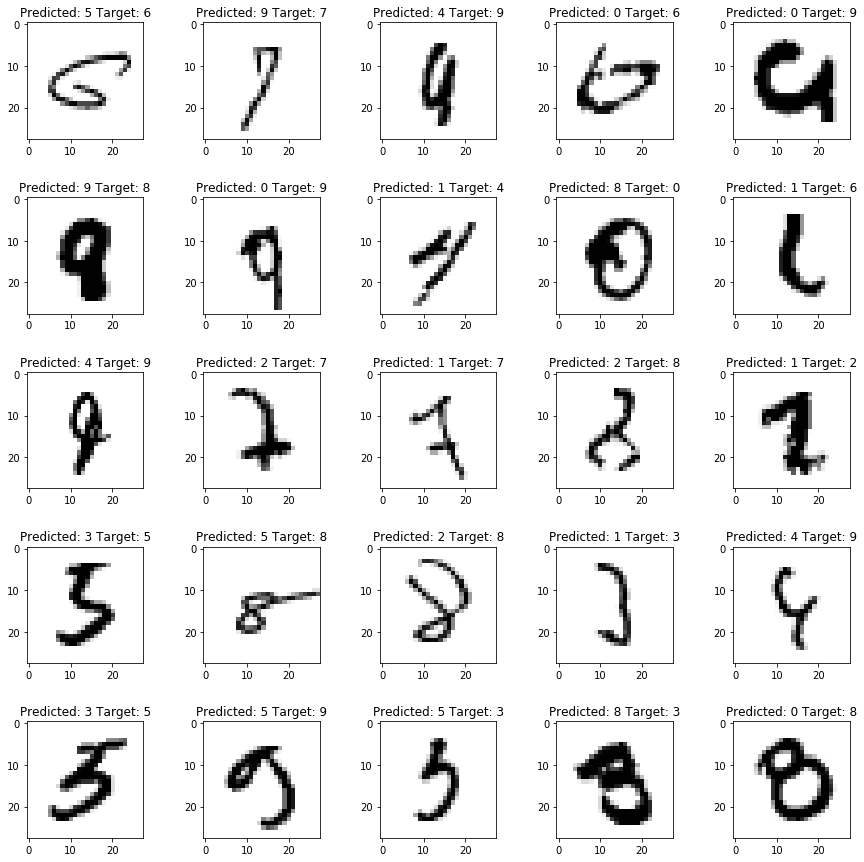

In [0]:
misclassified_images(misclassify)

In [0]:
train_acc_without_l1_l2 = train_acc.copy()
train_loss_without_l1_l2 = train_losses.copy()
test_acc_without_l1_l2 = test_acc.copy()
test_loss_without_l1_l2 = test_losses.copy()


Text(0.5, 1.0, 'Test Accuracy')

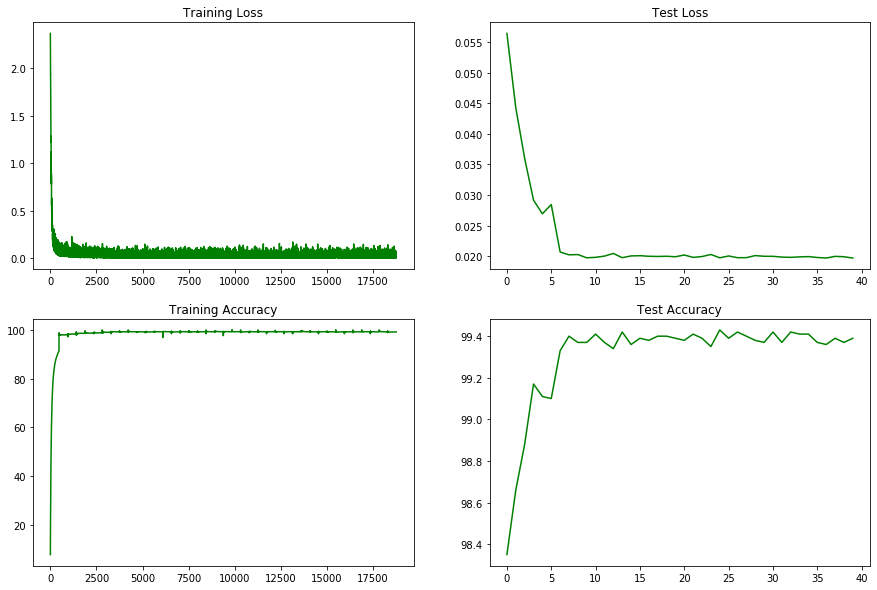

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_without_l1_l2,color = 'g')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc_without_l1_l2,color = 'g')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_loss_without_l1_l2,color = 'g')
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc_without_l1_l2,color = 'g')
axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L1**

In [0]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch,use_l1 = True,l1_factor=0.00005)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.08593752235174179 Batch_id=468 Accuracy=91.41: 100%|██████████| 469/469 [00:14<00:00, 36.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0760, Accuracy: 9788/10000 (97.88%)

EPOCH: 1 lr =  0.01


Loss=0.035476960241794586 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:15<00:00, 36.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9853/10000 (98.53%)

EPOCH: 2 lr =  0.01


Loss=0.051447637379169464 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:15<00:00, 38.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9875/10000 (98.75%)

EPOCH: 3 lr =  0.01


Loss=0.008210519328713417 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:15<00:00, 38.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9895/10000 (98.95%)

EPOCH: 4 lr =  0.01


Loss=0.02346331626176834 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9910/10000 (99.10%)

EPOCH: 5 lr =  0.01


Loss=0.06557722389698029 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9919/10000 (99.19%)

EPOCH: 6 lr =  0.001


Loss=0.1026846170425415 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:15<00:00, 29.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9932/10000 (99.32%)

EPOCH: 7 lr =  0.001


Loss=0.014471018686890602 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)

EPOCH: 8 lr =  0.0001


Loss=0.08413702994585037 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9928/10000 (99.28%)

EPOCH: 9 lr =  0.0001


Loss=0.009328429587185383 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

EPOCH: 10 lr =  0.0001


Loss=0.005433656275272369 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 37.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9930/10000 (99.30%)

EPOCH: 11 lr =  0.0001


Loss=0.09537255764007568 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 12 lr =  1e-05


Loss=0.02655968815088272 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 13 lr =  1e-05


Loss=0.030536672100424767 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

EPOCH: 14 lr =  1e-05


Loss=0.003981214947998524 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 29.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 15 lr =  1e-05


Loss=0.07876455038785934 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 16 lr =  1e-05


Loss=0.010798659175634384 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:15<00:00, 29.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9933/10000 (99.33%)

EPOCH: 17 lr =  1e-05


Loss=0.0037152604199945927 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:15<00:00, 30.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)

EPOCH: 18 lr =  1e-05


Loss=0.03370644152164459 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 19 lr =  1e-05


Loss=0.048640504479408264 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 30.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

EPOCH: 20 lr =  1e-05


Loss=0.03432232514023781 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 34.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 21 lr =  1e-05


Loss=0.0026963704731315374 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 35.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9931/10000 (99.31%)

EPOCH: 22 lr =  1e-05


Loss=0.008816061541438103 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)

EPOCH: 23 lr =  1e-05


Loss=0.07863688468933105 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 37.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9932/10000 (99.32%)

EPOCH: 24 lr =  1e-05


Loss=0.01038922555744648 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9932/10000 (99.32%)

EPOCH: 25 lr =  1e-05


Loss=0.014917650260031223 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9929/10000 (99.29%)

EPOCH: 26 lr =  1e-05


Loss=0.01639566756784916 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 27 lr =  1e-05


Loss=0.03710481524467468 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9935/10000 (99.35%)

EPOCH: 28 lr =  1e-05


Loss=0.006308202166110277 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

EPOCH: 29 lr =  1e-05


Loss=0.03378335013985634 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9931/10000 (99.31%)

EPOCH: 30 lr =  1e-05


Loss=0.023006442934274673 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)

EPOCH: 31 lr =  1e-05


Loss=0.08115123212337494 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 29.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9930/10000 (99.30%)

EPOCH: 32 lr =  1e-05


Loss=0.009353063069283962 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:15<00:00, 39.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH: 33 lr =  1e-05


Loss=0.04932905361056328 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 34 lr =  1e-05


Loss=0.010334914550185204 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9928/10000 (99.28%)

EPOCH: 35 lr =  1e-05


Loss=0.024353880435228348 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 30.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9934/10000 (99.34%)

EPOCH: 36 lr =  1e-05


Loss=0.0036994353868067265 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

EPOCH: 37 lr =  1e-05


Loss=0.009020538069307804 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:16<00:00, 34.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH: 38 lr =  1e-05


Loss=0.043330755084753036 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9931/10000 (99.31%)

EPOCH: 39 lr =  1e-05


Loss=0.009745322167873383 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]



Test set: Average loss: 0.0224, Accuracy: 9932/10000 (99.32%)



In [0]:
len(misclassify)

68

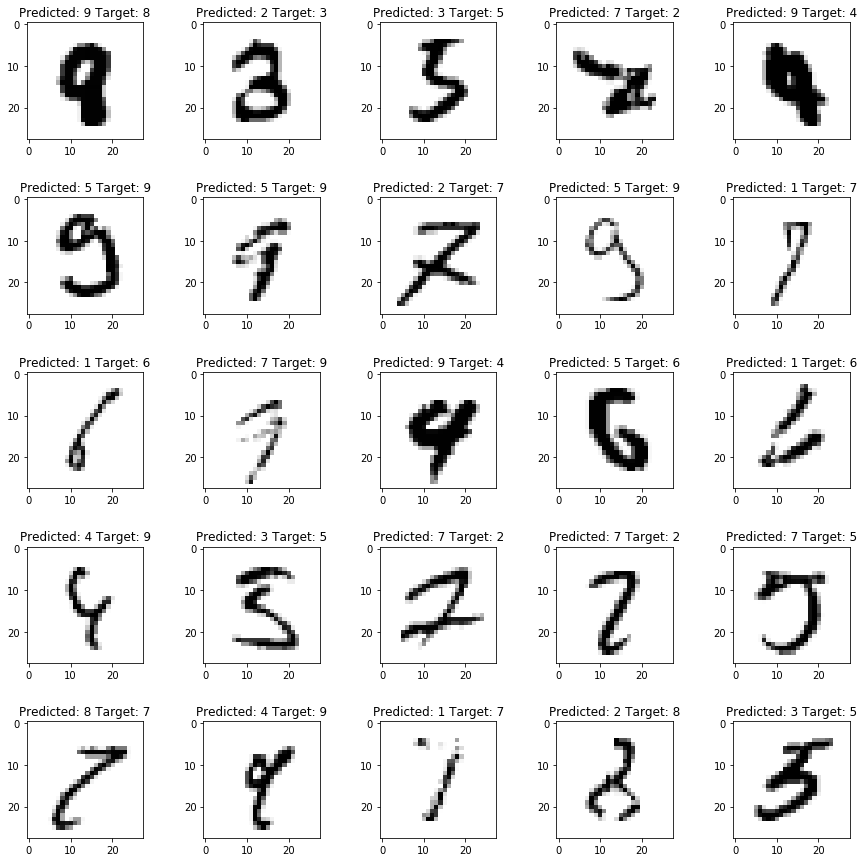

In [0]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l1 = train_acc.copy()
train_loss_with_l1 = train_losses.copy()
test_acc_with_l1 = test_acc.copy()
test_loss_with_l1 = test_losses.copy()

Text(0.5, 1.0, 'Test Accuracy')

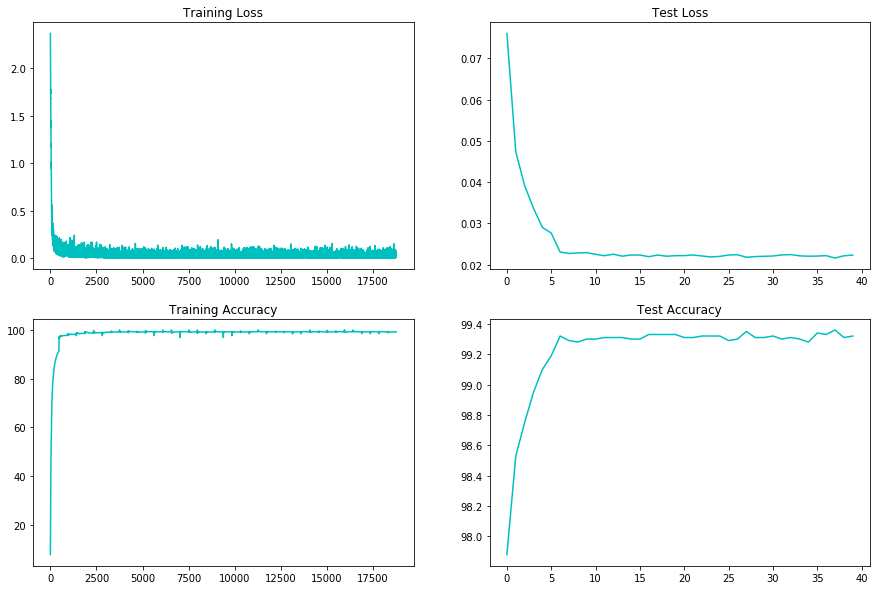

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_with_l1,color='c')
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l1,color='c')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l1,color='c')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l1,color='c')

axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L2**

In [41]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.05)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01



Loss=2.368736505508423 Batch_id=0 Accuracy=7.81:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=2.368736505508423 Batch_id=0 Accuracy=7.81:   0%|          | 1/469 [00:00<03:20,  2.34it/s]
Loss=2.351531505584717 Batch_id=1 Accuracy=7.42:   0%|          | 1/469 [00:00<03:20,  2.34it/s]
Loss=2.2586889266967773 Batch_id=2 Accuracy=9.38:   0%|          | 1/469 [00:00<03:20,  2.34it/s]
Loss=2.1652069091796875 Batch_id=3 Accuracy=11.33:   0%|          | 1/469 [00:00<03:20,  2.34it/s]
Loss=2.104853630065918 Batch_id=4 Accuracy=14.22:   0%|          | 1/469 [00:00<03:20,  2.34it/s] 
Loss=2.104853630065918 Batch_id=4 Accuracy=14.22:   1%|          | 5/469 [00:00<02:23,  3.24it/s]
Loss=2.0604381561279297 Batch_id=5 Accuracy=17.71:   1%|          | 5/469 [00:00<02:23,  3.24it/s]
Loss=1.9916306734085083 Batch_id=6 Accuracy=19.87:   1%|          | 5/469 [00:00<02:23,  3.24it/s]
Loss=1.8964136838912964 Batch_id=7 Accuracy=22.56:   1%|          | 5/469 [00:00<02:23,  3.24it/s]
Loss=1.760038137435913 Ba


Test set: Average loss: 0.4767, Accuracy: 9172/10000 (91.72%)

EPOCH: 1 lr =  0.01



Loss=0.2675562798976898 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.2675562798976898 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<03:03,  2.55it/s]
Loss=0.2815113365650177 Batch_id=1 Accuracy=96.88:   0%|          | 1/469 [00:00<03:03,  2.55it/s]
Loss=0.28098103404045105 Batch_id=2 Accuracy=96.88:   0%|          | 1/469 [00:00<03:03,  2.55it/s]
Loss=0.25697746872901917 Batch_id=3 Accuracy=97.46:   0%|          | 1/469 [00:00<03:03,  2.55it/s]
Loss=0.25697746872901917 Batch_id=3 Accuracy=97.46:   1%|          | 4/469 [00:00<02:12,  3.50it/s]
Loss=0.2491874098777771 Batch_id=4 Accuracy=97.66:   1%|          | 4/469 [00:00<02:12,  3.50it/s] 
Loss=0.3291837275028229 Batch_id=5 Accuracy=97.53:   1%|          | 4/469 [00:00<02:12,  3.50it/s]
Loss=0.3381109833717346 Batch_id=6 Accuracy=97.21:   1%|          | 4/469 [00:00<02:12,  3.50it/s]
Loss=0.24396049976348877 Batch_id=7 Accuracy=97.27:   1%|          | 4/469 [00:00<02:12,  3.50it/s]
Loss=0.24396


Test set: Average loss: 0.3467, Accuracy: 9484/10000 (94.84%)

EPOCH: 2 lr =  0.01



Loss=0.2789025902748108 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.2789025902748108 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<03:06,  2.50it/s]
Loss=0.24496319890022278 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<03:06,  2.50it/s]
Loss=0.2810403108596802 Batch_id=2 Accuracy=98.18:   0%|          | 1/469 [00:00<03:06,  2.50it/s] 
Loss=0.2666071653366089 Batch_id=3 Accuracy=97.66:   0%|          | 1/469 [00:00<03:06,  2.50it/s]
Loss=0.2888791263103485 Batch_id=4 Accuracy=97.19:   0%|          | 1/469 [00:00<03:06,  2.50it/s]
Loss=0.2888791263103485 Batch_id=4 Accuracy=97.19:   1%|          | 5/469 [00:00<02:13,  3.47it/s]
Loss=0.25013232231140137 Batch_id=5 Accuracy=97.14:   1%|          | 5/469 [00:00<02:13,  3.47it/s]
Loss=0.23012135922908783 Batch_id=6 Accuracy=97.32:   1%|          | 5/469 [00:00<02:13,  3.47it/s]
Loss=0.2962173819541931 Batch_id=7 Accuracy=97.36:   1%|          | 5/469 [00:00<02:13,  3.47it/s] 
Loss=0.29621


Test set: Average loss: 0.2715, Accuracy: 9728/10000 (97.28%)

EPOCH: 3 lr =  0.01



Loss=0.2822388708591461 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.2822388708591461 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<03:35,  2.18it/s]
Loss=0.29197612404823303 Batch_id=1 Accuracy=95.70:   0%|          | 1/469 [00:00<03:35,  2.18it/s]
Loss=0.2564759850502014 Batch_id=2 Accuracy=96.35:   0%|          | 1/469 [00:00<03:35,  2.18it/s] 
Loss=0.2868724465370178 Batch_id=3 Accuracy=96.29:   0%|          | 1/469 [00:00<03:35,  2.18it/s]
Loss=0.2868724465370178 Batch_id=3 Accuracy=96.29:   1%|          | 4/469 [00:00<02:34,  3.00it/s]
Loss=0.25698885321617126 Batch_id=4 Accuracy=96.41:   1%|          | 4/469 [00:00<02:34,  3.00it/s]
Loss=0.25332435965538025 Batch_id=5 Accuracy=96.61:   1%|          | 4/469 [00:00<02:34,  3.00it/s]
Loss=0.2471308708190918 Batch_id=6 Accuracy=96.88:   1%|          | 4/469 [00:00<02:34,  3.00it/s] 
Loss=0.29394418001174927 Batch_id=7 Accuracy=96.97:   1%|          | 4/469 [00:00<02:34,  3.00it/s]
Loss=0.2939


Test set: Average loss: 0.3265, Accuracy: 9722/10000 (97.22%)

EPOCH: 4 lr =  0.01



Loss=0.2309006154537201 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.2309006154537201 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:22,  2.31it/s]
Loss=0.2641640603542328 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<03:22,  2.31it/s]
Loss=0.2680971026420593 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<03:22,  2.31it/s]
Loss=0.24080802500247955 Batch_id=3 Accuracy=98.05:   0%|          | 1/469 [00:00<03:22,  2.31it/s]
Loss=0.24080802500247955 Batch_id=3 Accuracy=98.05:   1%|          | 4/469 [00:00<02:26,  3.17it/s]
Loss=0.29156729578971863 Batch_id=4 Accuracy=97.50:   1%|          | 4/469 [00:00<02:26,  3.17it/s]
Loss=0.3302156329154968 Batch_id=5 Accuracy=97.01:   1%|          | 4/469 [00:00<02:26,  3.17it/s] 
Loss=0.3014688491821289 Batch_id=6 Accuracy=96.88:   1%|          | 4/469 [00:00<02:26,  3.17it/s]
Loss=0.3014688491821289 Batch_id=6 Accuracy=96.88:   1%|▏         | 7/469 [00:00<01:46,  4.33it/s]
Loss=0.250248


Test set: Average loss: 0.5159, Accuracy: 8810/10000 (88.10%)

EPOCH: 5 lr =  0.01



Loss=0.23928511142730713 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.23928511142730713 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:25,  2.28it/s]
Loss=0.24898415803909302 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<03:25,  2.28it/s]
Loss=0.26780012249946594 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<03:25,  2.28it/s]
Loss=0.23204417526721954 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<03:25,  2.28it/s]
Loss=0.2697891294956207 Batch_id=4 Accuracy=98.28:   0%|          | 1/469 [00:00<03:25,  2.28it/s] 
Loss=0.2697891294956207 Batch_id=4 Accuracy=98.28:   1%|          | 5/469 [00:00<02:27,  3.15it/s]
Loss=0.22272366285324097 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<02:27,  3.15it/s]
Loss=0.22969280183315277 Batch_id=6 Accuracy=98.66:   1%|          | 5/469 [00:00<02:27,  3.15it/s]
Loss=0.2841937243938446 Batch_id=7 Accuracy=98.44:   1%|          | 5/469 [00:00<02:27,  3.15it/s] 
Loss=0.3


Test set: Average loss: 0.3676, Accuracy: 9441/10000 (94.41%)

EPOCH: 6 lr =  0.001



Loss=0.308472603559494 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.308472603559494 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<03:16,  2.38it/s]
Loss=0.26551687717437744 Batch_id=1 Accuracy=96.88:   0%|          | 1/469 [00:00<03:16,  2.38it/s]
Loss=0.2693900167942047 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<03:16,  2.38it/s] 
Loss=0.29777172207832336 Batch_id=3 Accuracy=96.88:   0%|          | 1/469 [00:00<03:16,  2.38it/s]
Loss=0.29777172207832336 Batch_id=3 Accuracy=96.88:   1%|          | 4/469 [00:00<02:22,  3.26it/s]
Loss=0.2576047480106354 Batch_id=4 Accuracy=97.19:   1%|          | 4/469 [00:00<02:22,  3.26it/s] 
Loss=0.2862388491630554 Batch_id=5 Accuracy=97.01:   1%|          | 4/469 [00:00<02:22,  3.26it/s]
Loss=0.24192774295806885 Batch_id=6 Accuracy=97.32:   1%|          | 4/469 [00:00<02:22,  3.26it/s]
Loss=0.24192774295806885 Batch_id=6 Accuracy=97.32:   1%|▏         | 7/469 [00:00<01:44,  4.42it/s]
Loss=0.26797


Test set: Average loss: 0.1799, Accuracy: 9909/10000 (99.09%)

EPOCH: 7 lr =  0.001



Loss=0.21408012509346008 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.21408012509346008 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:16,  2.38it/s]
Loss=0.1926937997341156 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<03:16,  2.38it/s] 
Loss=0.24178670346736908 Batch_id=2 Accuracy=98.44:   0%|          | 1/469 [00:00<03:16,  2.38it/s]
Loss=0.24327340722084045 Batch_id=3 Accuracy=98.44:   0%|          | 1/469 [00:00<03:16,  2.38it/s]
Loss=0.18047481775283813 Batch_id=4 Accuracy=98.75:   0%|          | 1/469 [00:00<03:16,  2.38it/s]
Loss=0.18047481775283813 Batch_id=4 Accuracy=98.75:   1%|          | 5/469 [00:00<02:21,  3.29it/s]
Loss=0.25260934233665466 Batch_id=5 Accuracy=98.44:   1%|          | 5/469 [00:00<02:21,  3.29it/s]
Loss=0.22819752991199493 Batch_id=6 Accuracy=98.33:   1%|          | 5/469 [00:00<02:21,  3.29it/s]
Loss=0.2056257575750351 Batch_id=7 Accuracy=98.34:   1%|          | 5/469 [00:00<02:21,  3.29it/s] 
Loss=0.


Test set: Average loss: 0.2110, Accuracy: 9823/10000 (98.23%)

EPOCH: 8 lr =  0.0001



Loss=0.19506937265396118 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.19506937265396118 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:28,  2.24it/s]
Loss=0.22871825098991394 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<03:28,  2.24it/s] 
Loss=0.1816948503255844 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<03:28,  2.24it/s] 
Loss=0.23663285374641418 Batch_id=3 Accuracy=99.22:   0%|          | 1/469 [00:00<03:28,  2.24it/s]
Loss=0.19933687150478363 Batch_id=4 Accuracy=99.06:   0%|          | 1/469 [00:00<03:28,  2.24it/s]
Loss=0.1922239065170288 Batch_id=5 Accuracy=99.09:   0%|          | 1/469 [00:00<03:28,  2.24it/s] 
Loss=0.1922239065170288 Batch_id=5 Accuracy=99.09:   1%|▏         | 6/469 [00:00<02:27,  3.13it/s]
Loss=0.17634373903274536 Batch_id=6 Accuracy=99.22:   1%|▏         | 6/469 [00:00<02:27,  3.13it/s]
Loss=0.20121854543685913 Batch_id=7 Accuracy=99.32:   1%|▏         | 6/469 [00:00<02:27,  3.13it/s]
Loss=


Test set: Average loss: 0.1712, Accuracy: 9936/10000 (99.36%)

EPOCH: 9 lr =  0.0001



Loss=0.19970524311065674 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.19970524311065674 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:46,  2.81it/s]
Loss=0.19602070748806 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:46,  2.81it/s]   
Loss=0.18551209568977356 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:46,  2.81it/s]
Loss=0.18551209568977356 Batch_id=2 Accuracy=99.22:   1%|          | 3/469 [00:00<02:04,  3.75it/s]
Loss=0.17976519465446472 Batch_id=3 Accuracy=99.41:   1%|          | 3/469 [00:00<02:04,  3.75it/s]
Loss=0.199612557888031 Batch_id=4 Accuracy=99.22:   1%|          | 3/469 [00:00<02:04,  3.75it/s]  
Loss=0.18018102645874023 Batch_id=5 Accuracy=99.35:   1%|          | 3/469 [00:00<02:04,  3.75it/s]
Loss=0.20797216892242432 Batch_id=6 Accuracy=99.22:   1%|          | 3/469 [00:00<02:04,  3.75it/s]
Loss=0.20797216892242432 Batch_id=6 Accuracy=99.22:   1%|▏         | 7/469 [00:00<01:29,  5.16it/s]
Loss=0.


Test set: Average loss: 0.1701, Accuracy: 9941/10000 (99.41%)

EPOCH: 10 lr =  0.0001



Loss=0.2129291146993637 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.2129291146993637 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:27,  2.25it/s]
Loss=0.19569921493530273 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<03:27,  2.25it/s]
Loss=0.17254729568958282 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<03:27,  2.25it/s]
Loss=0.22095197439193726 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<03:27,  2.25it/s]
Loss=0.22095197439193726 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<02:29,  3.12it/s]
Loss=0.18688592314720154 Batch_id=4 Accuracy=99.06:   1%|          | 4/469 [00:00<02:29,  3.12it/s]
Loss=0.19618140161037445 Batch_id=5 Accuracy=98.96:   1%|          | 4/469 [00:00<02:29,  3.12it/s]
Loss=0.18510474264621735 Batch_id=6 Accuracy=99.00:   1%|          | 4/469 [00:00<02:29,  3.12it/s]
Loss=0.1954784393310547 Batch_id=7 Accuracy=99.02:   1%|          | 4/469 [00:00<02:29,  3.12it/s] 
Loss=0.19


Test set: Average loss: 0.1680, Accuracy: 9937/10000 (99.37%)

EPOCH: 11 lr =  0.0001



Loss=0.1961234211921692 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.1961234211921692 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:20,  2.33it/s]
Loss=0.20398332178592682 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<03:20,  2.33it/s]
Loss=0.2094527781009674 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<03:20,  2.33it/s] 
Loss=0.20896731317043304 Batch_id=3 Accuracy=98.83:   0%|          | 1/469 [00:00<03:20,  2.33it/s]
Loss=0.21006231009960175 Batch_id=4 Accuracy=98.75:   0%|          | 1/469 [00:00<03:20,  2.33it/s]
Loss=0.21006231009960175 Batch_id=4 Accuracy=98.75:   1%|          | 5/469 [00:00<02:23,  3.24it/s]
Loss=0.20462842285633087 Batch_id=5 Accuracy=98.83:   1%|          | 5/469 [00:00<02:23,  3.24it/s]
Loss=0.17976918816566467 Batch_id=6 Accuracy=99.00:   1%|          | 5/469 [00:00<02:23,  3.24it/s]
Loss=0.20341992378234863 Batch_id=7 Accuracy=99.02:   1%|          | 5/469 [00:00<02:23,  3.24it/s]
Loss=0.18


Test set: Average loss: 0.1684, Accuracy: 9935/10000 (99.35%)

EPOCH: 12 lr =  1e-05



Loss=0.1924007683992386 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.1924007683992386 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:20,  2.33it/s]
Loss=0.2056145966053009 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<03:20,  2.33it/s] 
Loss=0.1979948729276657 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<03:20,  2.33it/s]
Loss=0.1824156641960144 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<03:20,  2.33it/s]
Loss=0.1746467798948288 Batch_id=4 Accuracy=99.53:   0%|          | 1/469 [00:00<03:20,  2.33it/s]
Loss=0.1746467798948288 Batch_id=4 Accuracy=99.53:   1%|          | 5/469 [00:00<02:23,  3.23it/s]
Loss=0.17685329914093018 Batch_id=5 Accuracy=99.61:   1%|          | 5/469 [00:00<02:23,  3.23it/s]
Loss=0.24636894464492798 Batch_id=6 Accuracy=99.22:   1%|          | 5/469 [00:00<02:23,  3.23it/s]
Loss=0.1828724890947342 Batch_id=7 Accuracy=99.22:   1%|          | 5/469 [00:00<02:23,  3.23it/s] 
Loss=0.1829


Test set: Average loss: 0.1687, Accuracy: 9935/10000 (99.35%)

EPOCH: 13 lr =  1e-05



Loss=0.20939147472381592 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.20939147472381592 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:21,  2.32it/s]
Loss=0.19600801169872284 Batch_id=1 Accuracy=98.44:   0%|          | 1/469 [00:00<03:21,  2.32it/s]
Loss=0.1737431287765503 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<03:21,  2.32it/s] 
Loss=0.20158809423446655 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<03:21,  2.32it/s]
Loss=0.18021443486213684 Batch_id=4 Accuracy=99.22:   0%|          | 1/469 [00:00<03:21,  2.32it/s]
Loss=0.18021443486213684 Batch_id=4 Accuracy=99.22:   1%|          | 5/469 [00:00<02:24,  3.21it/s]
Loss=0.17446036636829376 Batch_id=5 Accuracy=99.35:   1%|          | 5/469 [00:00<02:24,  3.21it/s]
Loss=0.19338558614253998 Batch_id=6 Accuracy=99.33:   1%|          | 5/469 [00:00<02:24,  3.21it/s]
Loss=0.21495816111564636 Batch_id=7 Accuracy=99.22:   1%|          | 5/469 [00:00<02:24,  3.21it/s]
Loss=0.


Test set: Average loss: 0.1678, Accuracy: 9941/10000 (99.41%)

EPOCH: 14 lr =  1e-05



Loss=0.17820662260055542 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.17820662260055542 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:07,  2.50it/s]
Loss=0.18207260966300964 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<03:07,  2.50it/s]
Loss=0.17905811965465546 Batch_id=2 Accuracy=100.00:   0%|          | 1/469 [00:00<03:07,  2.50it/s]
Loss=0.18151406943798065 Batch_id=3 Accuracy=99.80:   0%|          | 1/469 [00:00<03:07,  2.50it/s] 
Loss=0.1653384417295456 Batch_id=4 Accuracy=99.84:   0%|          | 1/469 [00:00<03:07,  2.50it/s] 
Loss=0.1653384417295456 Batch_id=4 Accuracy=99.84:   1%|          | 5/469 [00:00<02:13,  3.46it/s]
Loss=0.17744874954223633 Batch_id=5 Accuracy=99.87:   1%|          | 5/469 [00:00<02:13,  3.46it/s]
Loss=0.17921182513237 Batch_id=6 Accuracy=99.89:   1%|          | 5/469 [00:00<02:13,  3.46it/s]   
Loss=0.1917767971754074 Batch_id=7 Accuracy=99.80:   1%|          | 5/469 [00:00<02:13,  3.46it/s]
Loss


Test set: Average loss: 0.1673, Accuracy: 9941/10000 (99.41%)

EPOCH: 15 lr =  1e-05



Loss=0.22788845002651215 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.22788845002651215 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<03:18,  2.36it/s]
Loss=0.20003922283649445 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<03:18,  2.36it/s]
Loss=0.1673259288072586 Batch_id=2 Accuracy=98.70:   0%|          | 1/469 [00:00<03:18,  2.36it/s] 
Loss=0.17710843682289124 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<03:18,  2.36it/s]
Loss=0.1900094896554947 Batch_id=4 Accuracy=99.06:   0%|          | 1/469 [00:00<03:18,  2.36it/s] 
Loss=0.18362000584602356 Batch_id=5 Accuracy=99.22:   0%|          | 1/469 [00:00<03:18,  2.36it/s]
Loss=0.18362000584602356 Batch_id=5 Accuracy=99.22:   1%|▏         | 6/469 [00:00<02:20,  3.30it/s]
Loss=0.18988634645938873 Batch_id=6 Accuracy=99.33:   1%|▏         | 6/469 [00:00<02:20,  3.30it/s]
Loss=0.16966526210308075 Batch_id=7 Accuracy=99.41:   1%|▏         | 6/469 [00:00<02:20,  3.30it/s]
Loss=0.


Test set: Average loss: 0.1692, Accuracy: 9939/10000 (99.39%)

EPOCH: 16 lr =  1e-05



Loss=0.1936507523059845 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.1936507523059845 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<04:12,  1.85it/s]
Loss=0.17742601037025452 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<04:12,  1.85it/s]
Loss=0.20663465559482574 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<04:12,  1.85it/s]
Loss=0.20312970876693726 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<04:12,  1.85it/s]
Loss=0.20312970876693726 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<03:00,  2.57it/s]
Loss=0.1745716780424118 Batch_id=4 Accuracy=99.53:   1%|          | 4/469 [00:00<03:00,  2.57it/s] 
Loss=0.17865416407585144 Batch_id=5 Accuracy=99.61:   1%|          | 4/469 [00:00<03:00,  2.57it/s]
Loss=0.1829308122396469 Batch_id=6 Accuracy=99.67:   1%|          | 4/469 [00:00<03:00,  2.57it/s] 
Loss=0.18916106224060059 Batch_id=7 Accuracy=99.61:   1%|          | 4/469 [00:00<03:00,  2.57it/s]
Loss=0.18


Test set: Average loss: 0.1685, Accuracy: 9941/10000 (99.41%)

EPOCH: 17 lr =  1e-05



Loss=0.19128923118114471 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.19128923118114471 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:29,  2.23it/s]
Loss=0.19403061270713806 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<03:29,  2.23it/s]
Loss=0.1904006153345108 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<03:29,  2.23it/s] 
Loss=0.18230219185352325 Batch_id=3 Accuracy=99.22:   0%|          | 1/469 [00:00<03:29,  2.23it/s]
Loss=0.18230219185352325 Batch_id=3 Accuracy=99.22:   1%|          | 4/469 [00:00<02:30,  3.09it/s]
Loss=0.18582694232463837 Batch_id=4 Accuracy=99.38:   1%|          | 4/469 [00:00<02:30,  3.09it/s]
Loss=0.1907215714454651 Batch_id=5 Accuracy=99.35:   1%|          | 4/469 [00:00<02:30,  3.09it/s] 
Loss=0.19396229088306427 Batch_id=6 Accuracy=99.44:   1%|          | 4/469 [00:00<02:30,  3.09it/s]
Loss=0.18880178034305573 Batch_id=7 Accuracy=99.51:   1%|          | 4/469 [00:00<02:30,  3.09it/s]
Loss=0.


Test set: Average loss: 0.1660, Accuracy: 9938/10000 (99.38%)

EPOCH: 18 lr =  1e-05



Loss=0.21638675034046173 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.21638675034046173 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:06,  2.51it/s]
Loss=0.21787840127944946 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<03:06,  2.51it/s]
Loss=0.21422895789146423 Batch_id=2 Accuracy=97.92:   0%|          | 1/469 [00:00<03:06,  2.51it/s]
Loss=0.18356992304325104 Batch_id=3 Accuracy=98.24:   0%|          | 1/469 [00:00<03:06,  2.51it/s]
Loss=0.19508635997772217 Batch_id=4 Accuracy=98.44:   0%|          | 1/469 [00:00<03:06,  2.51it/s]
Loss=0.19508635997772217 Batch_id=4 Accuracy=98.44:   1%|          | 5/469 [00:00<02:13,  3.47it/s]
Loss=0.23351195454597473 Batch_id=5 Accuracy=98.31:   1%|          | 5/469 [00:00<02:13,  3.47it/s]
Loss=0.17444103956222534 Batch_id=6 Accuracy=98.55:   1%|          | 5/469 [00:00<02:13,  3.47it/s]
Loss=0.19146530330181122 Batch_id=7 Accuracy=98.63:   1%|          | 5/469 [00:00<02:13,  3.47it/s]
Loss=0.


Test set: Average loss: 0.1677, Accuracy: 9936/10000 (99.36%)

EPOCH: 19 lr =  1e-05



Loss=0.1880941390991211 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.1880941390991211 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<02:58,  2.62it/s]
Loss=0.18191640079021454 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<02:58,  2.62it/s]
Loss=0.19278310239315033 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<02:58,  2.62it/s]
Loss=0.18776477873325348 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<02:58,  2.62it/s]
Loss=0.20129676163196564 Batch_id=4 Accuracy=99.22:   0%|          | 1/469 [00:00<02:58,  2.62it/s]
Loss=0.20129676163196564 Batch_id=4 Accuracy=99.22:   1%|          | 5/469 [00:00<02:08,  3.60it/s]
Loss=0.18405354022979736 Batch_id=5 Accuracy=99.35:   1%|          | 5/469 [00:00<02:08,  3.60it/s]
Loss=0.20059430599212646 Batch_id=6 Accuracy=99.33:   1%|          | 5/469 [00:00<02:08,  3.60it/s]
Loss=0.19332987070083618 Batch_id=7 Accuracy=99.41:   1%|          | 5/469 [00:00<02:08,  3.60it/s]
Loss=0.18


Test set: Average loss: 0.1663, Accuracy: 9940/10000 (99.40%)

EPOCH: 20 lr =  1e-05



Loss=0.19875659048557281 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.19875659048557281 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:18,  2.35it/s]
Loss=0.18960759043693542 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<03:18,  2.35it/s]
Loss=0.17878663539886475 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<03:18,  2.35it/s]
Loss=0.17823629081249237 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<03:18,  2.35it/s]
Loss=0.19881011545658112 Batch_id=4 Accuracy=99.53:   0%|          | 1/469 [00:00<03:18,  2.35it/s]
Loss=0.19881011545658112 Batch_id=4 Accuracy=99.53:   1%|          | 5/469 [00:00<02:21,  3.28it/s]
Loss=0.22043368220329285 Batch_id=5 Accuracy=99.35:   1%|          | 5/469 [00:00<02:21,  3.28it/s]
Loss=0.19202874600887299 Batch_id=6 Accuracy=99.44:   1%|          | 5/469 [00:00<02:21,  3.28it/s]
Loss=0.24185828864574432 Batch_id=7 Accuracy=99.22:   1%|          | 5/469 [00:00<02:21,  3.28it/s]
Loss=0.


Test set: Average loss: 0.1671, Accuracy: 9938/10000 (99.38%)

EPOCH: 21 lr =  1e-05



Loss=0.18416859209537506 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.18416859209537506 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:28,  2.24it/s]
Loss=0.20870105922222137 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<03:28,  2.24it/s]
Loss=0.17292256653308868 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<03:28,  2.24it/s]
Loss=0.18835897743701935 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<03:28,  2.24it/s]
Loss=0.18835897743701935 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<02:30,  3.09it/s]
Loss=0.18100056052207947 Batch_id=4 Accuracy=99.53:   1%|          | 4/469 [00:00<02:30,  3.09it/s]
Loss=0.2227708101272583 Batch_id=5 Accuracy=99.35:   1%|          | 4/469 [00:00<02:30,  3.09it/s] 
Loss=0.2152678221464157 Batch_id=6 Accuracy=99.22:   1%|          | 4/469 [00:00<02:30,  3.09it/s]
Loss=0.19860149919986725 Batch_id=7 Accuracy=99.22:   1%|          | 4/469 [00:00<02:30,  3.09it/s]
Loss=0.2


Test set: Average loss: 0.1668, Accuracy: 9938/10000 (99.38%)

EPOCH: 22 lr =  1e-05



Loss=0.18080997467041016 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.18080997467041016 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:23,  2.30it/s]
Loss=0.18087273836135864 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<03:23,  2.30it/s] 
Loss=0.19412879645824432 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<03:23,  2.30it/s]
Loss=0.1903461515903473 Batch_id=3 Accuracy=99.80:   0%|          | 1/469 [00:00<03:23,  2.30it/s] 
Loss=0.24852527678012848 Batch_id=4 Accuracy=99.22:   0%|          | 1/469 [00:00<03:23,  2.30it/s]
Loss=0.24852527678012848 Batch_id=4 Accuracy=99.22:   1%|          | 5/469 [00:00<02:25,  3.19it/s]
Loss=0.18544098734855652 Batch_id=5 Accuracy=99.35:   1%|          | 5/469 [00:00<02:25,  3.19it/s]
Loss=0.18332798779010773 Batch_id=6 Accuracy=99.44:   1%|          | 5/469 [00:00<02:25,  3.19it/s]
Loss=0.23570767045021057 Batch_id=7 Accuracy=99.32:   1%|          | 5/469 [00:00<02:25,  3.19it/s]
Loss


Test set: Average loss: 0.1667, Accuracy: 9937/10000 (99.37%)

EPOCH: 23 lr =  1e-05



Loss=0.1922614574432373 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.1922614574432373 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:03,  2.55it/s]
Loss=0.18664921820163727 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<03:03,  2.55it/s]
Loss=0.20189811289310455 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<03:03,  2.55it/s] 
Loss=0.20189811289310455 Batch_id=2 Accuracy=99.74:   1%|          | 3/469 [00:00<02:16,  3.40it/s]
Loss=0.17228002846240997 Batch_id=3 Accuracy=99.80:   1%|          | 3/469 [00:00<02:16,  3.40it/s]
Loss=0.19833149015903473 Batch_id=4 Accuracy=99.53:   1%|          | 3/469 [00:00<02:16,  3.40it/s]
Loss=0.18387579917907715 Batch_id=5 Accuracy=99.61:   1%|          | 3/469 [00:00<02:16,  3.40it/s]
Loss=0.18432429432868958 Batch_id=6 Accuracy=99.55:   1%|          | 3/469 [00:00<02:16,  3.40it/s]
Loss=0.21222318708896637 Batch_id=7 Accuracy=99.51:   1%|          | 3/469 [00:00<02:16,  3.40it/s]
Loss=


Test set: Average loss: 0.1655, Accuracy: 9938/10000 (99.38%)

EPOCH: 24 lr =  1e-05



Loss=0.2037307471036911 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.2037307471036911 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:16,  2.38it/s]
Loss=0.17728999257087708 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<03:16,  2.38it/s]
Loss=0.17728999257087708 Batch_id=1 Accuracy=100.00:   0%|          | 2/469 [00:00<02:32,  3.06it/s]
Loss=0.18564368784427643 Batch_id=2 Accuracy=99.48:   0%|          | 2/469 [00:00<02:32,  3.06it/s] 
Loss=0.17963576316833496 Batch_id=3 Accuracy=99.61:   0%|          | 2/469 [00:00<02:32,  3.06it/s]
Loss=0.19036054611206055 Batch_id=4 Accuracy=99.69:   0%|          | 2/469 [00:00<02:32,  3.06it/s]
Loss=0.20561973750591278 Batch_id=5 Accuracy=99.61:   0%|          | 2/469 [00:00<02:32,  3.06it/s]
Loss=0.18769699335098267 Batch_id=6 Accuracy=99.55:   0%|          | 2/469 [00:00<02:32,  3.06it/s]
Loss=0.18769699335098267 Batch_id=6 Accuracy=99.55:   1%|▏         | 7/469 [00:00<01:49,  4.23it/s]
Loss


Test set: Average loss: 0.1677, Accuracy: 9941/10000 (99.41%)

EPOCH: 25 lr =  1e-05



Loss=0.19287236034870148 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.19287236034870148 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:11,  2.44it/s]
Loss=0.18633505702018738 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<03:11,  2.44it/s]
Loss=0.19075502455234528 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<03:11,  2.44it/s]
Loss=0.19093769788742065 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<03:11,  2.44it/s]
Loss=0.19093769788742065 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<02:18,  3.36it/s]
Loss=0.1966855525970459 Batch_id=4 Accuracy=99.38:   1%|          | 4/469 [00:00<02:18,  3.36it/s] 
Loss=0.18336592614650726 Batch_id=5 Accuracy=99.48:   1%|          | 4/469 [00:00<02:18,  3.36it/s]
Loss=0.18896996974945068 Batch_id=6 Accuracy=99.44:   1%|          | 4/469 [00:00<02:18,  3.36it/s]
Loss=0.22650744020938873 Batch_id=7 Accuracy=99.22:   1%|          | 4/469 [00:00<02:18,  3.36it/s]
Loss=0.


Test set: Average loss: 0.1679, Accuracy: 9939/10000 (99.39%)

EPOCH: 26 lr =  1e-05



Loss=0.20707818865776062 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.20707818865776062 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:03,  2.54it/s]
Loss=0.18263962864875793 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<03:03,  2.54it/s]
Loss=0.21132034063339233 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<03:03,  2.54it/s]
Loss=0.21132034063339233 Batch_id=2 Accuracy=99.48:   1%|          | 3/469 [00:00<02:16,  3.41it/s]
Loss=0.2254692018032074 Batch_id=3 Accuracy=99.02:   1%|          | 3/469 [00:00<02:16,  3.41it/s] 
Loss=0.18706300854682922 Batch_id=4 Accuracy=99.22:   1%|          | 3/469 [00:00<02:16,  3.41it/s]
Loss=0.19383499026298523 Batch_id=5 Accuracy=99.35:   1%|          | 3/469 [00:00<02:16,  3.41it/s]
Loss=0.1827433854341507 Batch_id=6 Accuracy=99.44:   1%|          | 3/469 [00:00<02:16,  3.41it/s] 
Loss=0.1709074079990387 Batch_id=7 Accuracy=99.51:   1%|          | 3/469 [00:00<02:16,  3.41it/s]
Loss=0.1


Test set: Average loss: 0.1664, Accuracy: 9938/10000 (99.38%)

EPOCH: 27 lr =  1e-05



Loss=0.20031599700450897 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.20031599700450897 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:24,  2.29it/s]
Loss=0.17268888652324677 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<03:24,  2.29it/s]
Loss=0.19671644270420074 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<03:24,  2.29it/s]
Loss=0.17736218869686127 Batch_id=3 Accuracy=99.80:   0%|          | 1/469 [00:00<03:24,  2.29it/s]
Loss=0.17736218869686127 Batch_id=3 Accuracy=99.80:   1%|          | 4/469 [00:00<02:27,  3.16it/s]
Loss=0.17982791364192963 Batch_id=4 Accuracy=99.84:   1%|          | 4/469 [00:00<02:27,  3.16it/s]
Loss=0.1839415431022644 Batch_id=5 Accuracy=99.87:   1%|          | 4/469 [00:00<02:27,  3.16it/s] 
Loss=0.19862942397594452 Batch_id=6 Accuracy=99.78:   1%|          | 4/469 [00:00<02:27,  3.16it/s]
Loss=0.18982794880867004 Batch_id=7 Accuracy=99.80:   1%|          | 4/469 [00:00<02:27,  3.16it/s]
Loss=0.


Test set: Average loss: 0.1667, Accuracy: 9941/10000 (99.41%)

EPOCH: 28 lr =  1e-05



Loss=0.20283634960651398 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.20283634960651398 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:52,  2.72it/s]
Loss=0.17296169698238373 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<02:52,  2.72it/s]
Loss=0.18222545087337494 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<02:52,  2.72it/s]
Loss=0.18222545087337494 Batch_id=2 Accuracy=99.48:   1%|          | 3/469 [00:00<02:08,  3.64it/s]
Loss=0.18768377602100372 Batch_id=3 Accuracy=99.41:   1%|          | 3/469 [00:00<02:08,  3.64it/s]
Loss=0.22991803288459778 Batch_id=4 Accuracy=99.22:   1%|          | 3/469 [00:00<02:08,  3.64it/s]
Loss=0.18021756410598755 Batch_id=5 Accuracy=99.22:   1%|          | 3/469 [00:00<02:08,  3.64it/s]
Loss=0.1867101788520813 Batch_id=6 Accuracy=99.33:   1%|          | 3/469 [00:00<02:08,  3.64it/s] 
Loss=0.1867101788520813 Batch_id=6 Accuracy=99.33:   1%|▏         | 7/469 [00:00<01:32,  4.98it/s]
Loss=0.2


Test set: Average loss: 0.1673, Accuracy: 9938/10000 (99.38%)

EPOCH: 29 lr =  1e-05



Loss=0.18404416739940643 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.18404416739940643 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:18,  2.36it/s]
Loss=0.18719513714313507 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<03:18,  2.36it/s]
Loss=0.2069089710712433 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<03:18,  2.36it/s]  
Loss=0.1877320408821106 Batch_id=3 Accuracy=99.61:   0%|          | 1/469 [00:00<03:18,  2.36it/s]
Loss=0.1877320408821106 Batch_id=3 Accuracy=99.61:   1%|          | 4/469 [00:00<02:22,  3.26it/s]
Loss=0.1944172978401184 Batch_id=4 Accuracy=99.38:   1%|          | 4/469 [00:00<02:22,  3.26it/s]
Loss=0.19413898885250092 Batch_id=5 Accuracy=99.48:   1%|          | 4/469 [00:00<02:22,  3.26it/s]
Loss=0.18681307137012482 Batch_id=6 Accuracy=99.44:   1%|          | 4/469 [00:00<02:22,  3.26it/s]
Loss=0.2025727480649948 Batch_id=7 Accuracy=99.41:   1%|          | 4/469 [00:00<02:22,  3.26it/s] 
Loss=0


Test set: Average loss: 0.1674, Accuracy: 9940/10000 (99.40%)

EPOCH: 30 lr =  1e-05



Loss=0.17843171954154968 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.17843171954154968 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:18,  2.36it/s]
Loss=0.17540985345840454 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<03:18,  2.36it/s]
Loss=0.19305391609668732 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<03:18,  2.36it/s] 
Loss=0.18682128190994263 Batch_id=3 Accuracy=99.80:   0%|          | 1/469 [00:00<03:18,  2.36it/s]
Loss=0.18682128190994263 Batch_id=3 Accuracy=99.80:   1%|          | 4/469 [00:00<02:22,  3.26it/s]
Loss=0.2231195867061615 Batch_id=4 Accuracy=99.38:   1%|          | 4/469 [00:00<02:22,  3.26it/s] 
Loss=0.21131622791290283 Batch_id=5 Accuracy=99.22:   1%|          | 4/469 [00:00<02:22,  3.26it/s]
Loss=0.21069055795669556 Batch_id=6 Accuracy=99.22:   1%|          | 4/469 [00:00<02:22,  3.26it/s]
Loss=0.17077666521072388 Batch_id=7 Accuracy=99.32:   1%|          | 4/469 [00:00<02:22,  3.26it/s]
Los


Test set: Average loss: 0.1670, Accuracy: 9938/10000 (99.38%)

EPOCH: 31 lr =  1e-05



Loss=0.19014057517051697 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.19014057517051697 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:52,  2.02it/s]
Loss=0.19444680213928223 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<03:52,  2.02it/s] 
Loss=0.1789511889219284 Batch_id=2 Accuracy=99.48:   0%|          | 1/469 [00:00<03:52,  2.02it/s] 
Loss=0.19228892028331757 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<03:52,  2.02it/s]
Loss=0.19228892028331757 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<02:46,  2.80it/s]
Loss=0.20800888538360596 Batch_id=4 Accuracy=99.22:   1%|          | 4/469 [00:00<02:46,  2.80it/s]
Loss=0.18089301884174347 Batch_id=5 Accuracy=99.22:   1%|          | 4/469 [00:00<02:46,  2.80it/s]
Loss=0.17903022468090057 Batch_id=6 Accuracy=99.22:   1%|          | 4/469 [00:00<02:46,  2.80it/s]
Loss=0.17903022468090057 Batch_id=6 Accuracy=99.22:   1%|▏         | 7/469 [00:00<02:01,  3.82it/s]
Loss


Test set: Average loss: 0.1677, Accuracy: 9936/10000 (99.36%)

EPOCH: 32 lr =  1e-05



Loss=0.19700397551059723 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.19700397551059723 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:21,  2.33it/s]
Loss=0.2043193131685257 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<03:21,  2.33it/s] 
Loss=0.2076004296541214 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<03:21,  2.33it/s]
Loss=0.17019344866275787 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<03:21,  2.33it/s]
Loss=0.17019344866275787 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<02:25,  3.20it/s]
Loss=0.17861439287662506 Batch_id=4 Accuracy=99.53:   1%|          | 4/469 [00:00<02:25,  3.20it/s]
Loss=0.2444576770067215 Batch_id=5 Accuracy=99.22:   1%|          | 4/469 [00:00<02:25,  3.20it/s] 
Loss=0.18832655251026154 Batch_id=6 Accuracy=99.33:   1%|          | 4/469 [00:00<02:25,  3.20it/s]
Loss=0.19891919195652008 Batch_id=7 Accuracy=99.22:   1%|          | 4/469 [00:00<02:25,  3.20it/s]
Loss=0.1


Test set: Average loss: 0.1682, Accuracy: 9938/10000 (99.38%)

EPOCH: 33 lr =  1e-05



Loss=0.18308913707733154 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.18308913707733154 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:09,  2.47it/s]
Loss=0.16831791400909424 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<03:09,  2.47it/s]
Loss=0.1953003853559494 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<03:09,  2.47it/s]  
Loss=0.19763627648353577 Batch_id=3 Accuracy=99.61:   0%|          | 1/469 [00:00<03:09,  2.47it/s]
Loss=0.18680724501609802 Batch_id=4 Accuracy=99.53:   0%|          | 1/469 [00:00<03:09,  2.47it/s]
Loss=0.18680724501609802 Batch_id=4 Accuracy=99.53:   1%|          | 5/469 [00:00<02:15,  3.43it/s]
Loss=0.18406197428703308 Batch_id=5 Accuracy=99.61:   1%|          | 5/469 [00:00<02:15,  3.43it/s]
Loss=0.21235451102256775 Batch_id=6 Accuracy=99.44:   1%|          | 5/469 [00:00<02:15,  3.43it/s]
Loss=0.20453858375549316 Batch_id=7 Accuracy=99.41:   1%|          | 5/469 [00:00<02:15,  3.43it/s]
Los


Test set: Average loss: 0.1669, Accuracy: 9940/10000 (99.40%)

EPOCH: 34 lr =  1e-05



Loss=0.19198915362358093 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.19198915362358093 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:04,  2.54it/s]
Loss=0.17037518322467804 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<03:04,  2.54it/s]
Loss=0.21453142166137695 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<03:04,  2.54it/s] 
Loss=0.18787477910518646 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:00<03:04,  2.54it/s]
Loss=0.18787477910518646 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:00<02:13,  3.48it/s]
Loss=0.1943288892507553 Batch_id=4 Accuracy=99.06:   1%|          | 4/469 [00:00<02:13,  3.48it/s] 
Loss=0.1888071745634079 Batch_id=5 Accuracy=99.09:   1%|          | 4/469 [00:00<02:13,  3.48it/s]
Loss=0.18730735778808594 Batch_id=6 Accuracy=99.22:   1%|          | 4/469 [00:00<02:13,  3.48it/s]
Loss=0.17831942439079285 Batch_id=7 Accuracy=99.32:   1%|          | 4/469 [00:00<02:13,  3.48it/s]
Loss


Test set: Average loss: 0.1678, Accuracy: 9942/10000 (99.42%)

EPOCH: 35 lr =  1e-05



Loss=0.17793148756027222 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.17793148756027222 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:30,  2.23it/s]
Loss=0.1876494586467743 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<03:30,  2.23it/s] 
Loss=0.2097661942243576 Batch_id=2 Accuracy=99.22:   0%|          | 1/469 [00:00<03:30,  2.23it/s]
Loss=0.18332664668560028 Batch_id=3 Accuracy=99.41:   0%|          | 1/469 [00:00<03:30,  2.23it/s]
Loss=0.18332664668560028 Batch_id=3 Accuracy=99.41:   1%|          | 4/469 [00:00<02:31,  3.08it/s]
Loss=0.19241894781589508 Batch_id=4 Accuracy=99.38:   1%|          | 4/469 [00:00<02:31,  3.08it/s]
Loss=0.20994213223457336 Batch_id=5 Accuracy=99.35:   1%|          | 4/469 [00:00<02:31,  3.08it/s]
Loss=0.1736154705286026 Batch_id=6 Accuracy=99.44:   1%|          | 4/469 [00:00<02:31,  3.08it/s] 
Loss=0.18190878629684448 Batch_id=7 Accuracy=99.41:   1%|          | 4/469 [00:00<02:31,  3.08it/s]
Loss=0.1


Test set: Average loss: 0.1670, Accuracy: 9938/10000 (99.38%)

EPOCH: 36 lr =  1e-05



Loss=0.19885089993476868 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.19885089993476868 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:24,  2.29it/s]
Loss=0.20282384753227234 Batch_id=1 Accuracy=98.83:   0%|          | 1/469 [00:00<03:24,  2.29it/s]
Loss=0.19177380204200745 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<03:24,  2.29it/s]
Loss=0.1702212691307068 Batch_id=3 Accuracy=99.22:   0%|          | 1/469 [00:00<03:24,  2.29it/s] 
Loss=0.1702212691307068 Batch_id=3 Accuracy=99.22:   1%|          | 4/469 [00:00<02:27,  3.15it/s]
Loss=0.16567154228687286 Batch_id=4 Accuracy=99.38:   1%|          | 4/469 [00:00<02:27,  3.15it/s]
Loss=0.20652157068252563 Batch_id=5 Accuracy=99.09:   1%|          | 4/469 [00:00<02:27,  3.15it/s]
Loss=0.17548345029354095 Batch_id=6 Accuracy=99.22:   1%|          | 4/469 [00:00<02:27,  3.15it/s]
Loss=0.21715444326400757 Batch_id=7 Accuracy=99.02:   1%|          | 4/469 [00:00<02:27,  3.15it/s]
Loss=0.2


Test set: Average loss: 0.1680, Accuracy: 9940/10000 (99.40%)

EPOCH: 37 lr =  1e-05



Loss=0.1884935349225998 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.1884935349225998 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<06:52,  1.13it/s]
Loss=0.20218193531036377 Batch_id=1 Accuracy=99.22:   0%|          | 1/469 [00:00<06:52,  1.13it/s]
Loss=0.19675922393798828 Batch_id=2 Accuracy=98.96:   0%|          | 1/469 [00:00<06:52,  1.13it/s]
Loss=0.194203183054924 Batch_id=3 Accuracy=99.02:   0%|          | 1/469 [00:01<06:52,  1.13it/s]  
Loss=0.194203183054924 Batch_id=3 Accuracy=99.02:   1%|          | 4/469 [00:01<04:52,  1.59it/s]
Loss=0.21383905410766602 Batch_id=4 Accuracy=98.91:   1%|          | 4/469 [00:01<04:52,  1.59it/s]
Loss=0.2043629139661789 Batch_id=5 Accuracy=98.96:   1%|          | 4/469 [00:01<04:52,  1.59it/s] 
Loss=0.19248372316360474 Batch_id=6 Accuracy=99.00:   1%|          | 4/469 [00:01<04:52,  1.59it/s]
Loss=0.19248372316360474 Batch_id=6 Accuracy=99.00:   1%|▏         | 7/469 [00:01<03:29,  2.21it/s]
Loss=0.2059


Test set: Average loss: 0.1665, Accuracy: 9941/10000 (99.41%)

EPOCH: 38 lr =  1e-05



Loss=0.1794385462999344 Batch_id=0 Accuracy=100.00:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.1794385462999344 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<03:07,  2.49it/s]
Loss=0.18695886433124542 Batch_id=1 Accuracy=100.00:   0%|          | 1/469 [00:00<03:07,  2.49it/s]
Loss=0.18042278289794922 Batch_id=2 Accuracy=100.00:   0%|          | 1/469 [00:00<03:07,  2.49it/s]
Loss=0.18042278289794922 Batch_id=2 Accuracy=100.00:   1%|          | 3/469 [00:00<02:18,  3.37it/s]
Loss=0.19734421372413635 Batch_id=3 Accuracy=99.80:   1%|          | 3/469 [00:00<02:18,  3.37it/s] 
Loss=0.17626799643039703 Batch_id=4 Accuracy=99.69:   1%|          | 3/469 [00:00<02:18,  3.37it/s]
Loss=0.18564635515213013 Batch_id=5 Accuracy=99.74:   1%|          | 3/469 [00:00<02:18,  3.37it/s]
Loss=0.2005704790353775 Batch_id=6 Accuracy=99.78:   1%|          | 3/469 [00:00<02:18,  3.37it/s] 
Loss=0.2005704790353775 Batch_id=6 Accuracy=99.78:   1%|▏         | 7/469 [00:00<01:39,  4.64it/s]
Loss


Test set: Average loss: 0.1664, Accuracy: 9938/10000 (99.38%)

EPOCH: 39 lr =  1e-05



Loss=0.21346986293792725 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]
Loss=0.21346986293792725 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<03:09,  2.46it/s]
Loss=0.17380176484584808 Batch_id=1 Accuracy=99.61:   0%|          | 1/469 [00:00<03:09,  2.46it/s]
Loss=0.18565411865711212 Batch_id=2 Accuracy=99.74:   0%|          | 1/469 [00:00<03:09,  2.46it/s]
Loss=0.18565411865711212 Batch_id=2 Accuracy=99.74:   1%|          | 3/469 [00:00<02:21,  3.30it/s]
Loss=0.21575012803077698 Batch_id=3 Accuracy=99.61:   1%|          | 3/469 [00:00<02:21,  3.30it/s]
Loss=0.19983071088790894 Batch_id=4 Accuracy=99.69:   1%|          | 3/469 [00:00<02:21,  3.30it/s]
Loss=0.1831265687942505 Batch_id=5 Accuracy=99.74:   1%|          | 3/469 [00:00<02:21,  3.30it/s] 
Loss=0.1831265687942505 Batch_id=5 Accuracy=99.74:   1%|▏         | 6/469 [00:00<01:43,  4.48it/s]
Loss=0.20164498686790466 Batch_id=6 Accuracy=99.55:   1%|▏         | 6/469 [00:00<01:43,  4.48it/s]
Loss=0.1


Test set: Average loss: 0.1665, Accuracy: 9940/10000 (99.40%)



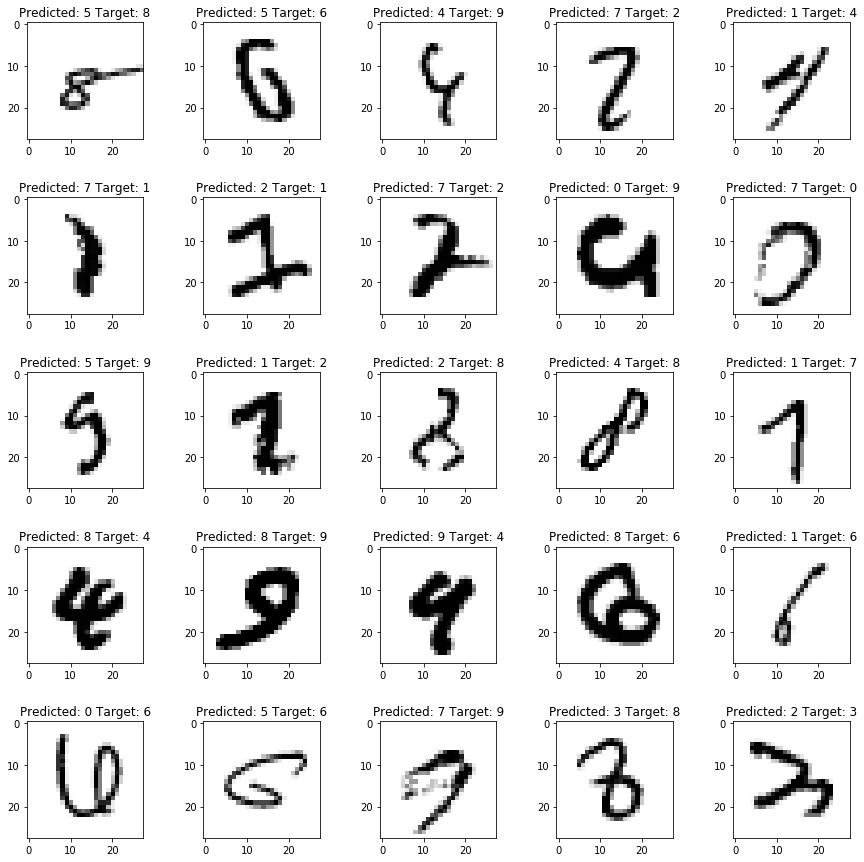

In [0]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l2 = train_acc.copy()
train_loss_with_l2 = train_losses.copy()
test_acc_with_l2 = test_acc.copy()
test_loss_with_l2 = test_losses.copy()


Text(0.5, 1.0, 'Test Accuracy')

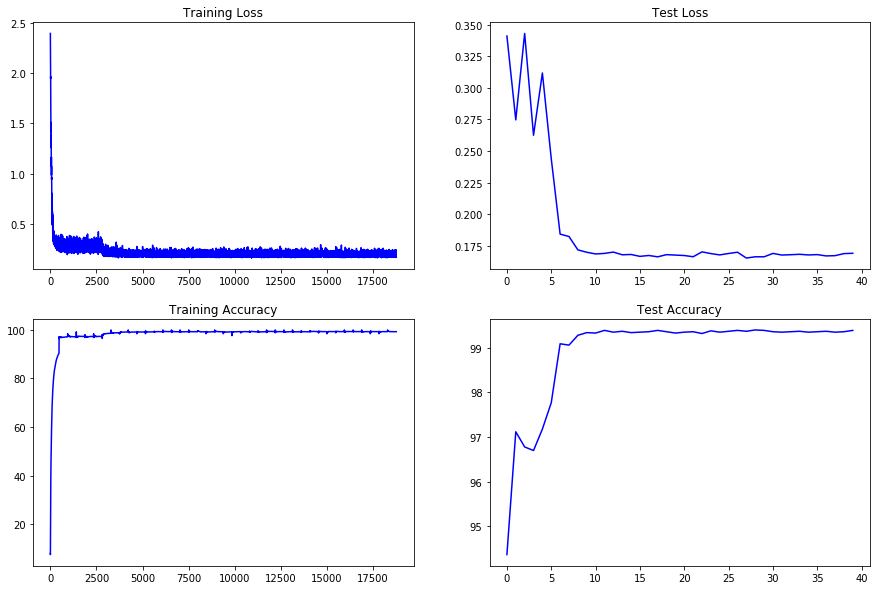

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_loss_with_l2,color = 'b')

axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l2,color = 'b')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l2,color = 'b')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l2,color = 'b')

axs[1, 1].set_title("Test Accuracy")

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# **With L1 and L2**

In [0]:
from torch.optim.lr_scheduler import StepLR,MultiStepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.05)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch,"lr = ",optimizer.param_groups[0]['lr'])
    train(model, device, train_loader, optimizer, epoch, use_l1 = True,l1_factor=0.00005)
    scheduler.step()
    misclassify = []
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0 lr =  0.01


Loss=0.2931460440158844 Batch_id=468 Accuracy=91.09: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3092, Accuracy: 9661/10000 (96.61%)

EPOCH: 1 lr =  0.01


Loss=0.24510376155376434 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:14<00:00, 32.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3151, Accuracy: 9712/10000 (97.12%)

EPOCH: 2 lr =  0.01


Loss=0.24095310270786285 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:15<00:00, 30.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2959, Accuracy: 9573/10000 (95.73%)

EPOCH: 3 lr =  0.01


Loss=0.23012275993824005 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:15<00:00, 30.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3116, Accuracy: 9691/10000 (96.91%)

EPOCH: 4 lr =  0.01


Loss=0.2384372502565384 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:15<00:00, 30.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2245, Accuracy: 9793/10000 (97.93%)

EPOCH: 5 lr =  0.01


Loss=0.3478514552116394 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3007, Accuracy: 9703/10000 (97.03%)

EPOCH: 6 lr =  0.001


Loss=0.18125630915164948 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1843, Accuracy: 9918/10000 (99.18%)

EPOCH: 7 lr =  0.001


Loss=0.2227289378643036 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:15<00:00, 30.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1861, Accuracy: 9906/10000 (99.06%)

EPOCH: 8 lr =  0.0001


Loss=0.2064274400472641 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1696, Accuracy: 9932/10000 (99.32%)

EPOCH: 9 lr =  0.0001


Loss=0.1975160837173462 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:15<00:00, 30.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1669, Accuracy: 9936/10000 (99.36%)

EPOCH: 10 lr =  0.0001


Loss=0.20480301976203918 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1663, Accuracy: 9938/10000 (99.38%)

EPOCH: 11 lr =  0.0001


Loss=0.2041291892528534 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:14<00:00, 42.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1680, Accuracy: 9935/10000 (99.35%)

EPOCH: 12 lr =  1e-05


Loss=0.1977025419473648 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 31.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1658, Accuracy: 9938/10000 (99.38%)

EPOCH: 13 lr =  1e-05


Loss=0.20733822882175446 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:15<00:00, 40.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1663, Accuracy: 9939/10000 (99.39%)

EPOCH: 14 lr =  1e-05


Loss=0.22993242740631104 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:15<00:00, 31.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1657, Accuracy: 9936/10000 (99.36%)

EPOCH: 15 lr =  1e-05


Loss=0.1949426680803299 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1648, Accuracy: 9937/10000 (99.37%)

EPOCH: 16 lr =  1e-05


Loss=0.1852390468120575 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1661, Accuracy: 9937/10000 (99.37%)

EPOCH: 17 lr =  1e-05


Loss=0.18430058658123016 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 41.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1655, Accuracy: 9935/10000 (99.35%)

EPOCH: 18 lr =  1e-05


Loss=0.19671222567558289 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1666, Accuracy: 9939/10000 (99.39%)

EPOCH: 19 lr =  1e-05


Loss=0.23228684067726135 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1651, Accuracy: 9938/10000 (99.38%)

EPOCH: 20 lr =  1e-05


Loss=0.18178273737430573 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1656, Accuracy: 9942/10000 (99.42%)

EPOCH: 21 lr =  1e-05


Loss=0.20157667994499207 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 39.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1659, Accuracy: 9935/10000 (99.35%)

EPOCH: 22 lr =  1e-05


Loss=0.17226433753967285 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1651, Accuracy: 9943/10000 (99.43%)

EPOCH: 23 lr =  1e-05


Loss=0.21168601512908936 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1654, Accuracy: 9941/10000 (99.41%)

EPOCH: 24 lr =  1e-05


Loss=0.20338010787963867 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1649, Accuracy: 9939/10000 (99.39%)

EPOCH: 25 lr =  1e-05


Loss=0.20435881614685059 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1648, Accuracy: 9941/10000 (99.41%)

EPOCH: 26 lr =  1e-05


Loss=0.18981513381004333 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1655, Accuracy: 9943/10000 (99.43%)

EPOCH: 27 lr =  1e-05


Loss=0.18253135681152344 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1646, Accuracy: 9941/10000 (99.41%)

EPOCH: 28 lr =  1e-05


Loss=0.17707324028015137 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 31.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1659, Accuracy: 9947/10000 (99.47%)

EPOCH: 29 lr =  1e-05


Loss=0.23082700371742249 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 31.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1663, Accuracy: 9937/10000 (99.37%)

EPOCH: 30 lr =  1e-05


Loss=0.24018090963363647 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:14<00:00, 31.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1656, Accuracy: 9942/10000 (99.42%)

EPOCH: 31 lr =  1e-05


Loss=0.17532698810100555 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:15<00:00, 30.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1655, Accuracy: 9942/10000 (99.42%)

EPOCH: 32 lr =  1e-05


Loss=0.18425360321998596 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1642, Accuracy: 9939/10000 (99.39%)

EPOCH: 33 lr =  1e-05


Loss=0.21236442029476166 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1647, Accuracy: 9940/10000 (99.40%)

EPOCH: 34 lr =  1e-05


Loss=0.19706930220127106 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:15<00:00, 40.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1652, Accuracy: 9944/10000 (99.44%)

EPOCH: 35 lr =  1e-05


Loss=0.21501591801643372 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:14<00:00, 34.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1649, Accuracy: 9940/10000 (99.40%)

EPOCH: 36 lr =  1e-05


Loss=0.17536629736423492 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 30.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1653, Accuracy: 9941/10000 (99.41%)

EPOCH: 37 lr =  1e-05


Loss=0.17676475644111633 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:15<00:00, 31.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1656, Accuracy: 9944/10000 (99.44%)

EPOCH: 38 lr =  1e-05


Loss=0.1880815625190735 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:14<00:00, 31.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1654, Accuracy: 9937/10000 (99.37%)

EPOCH: 39 lr =  1e-05


Loss=0.17921224236488342 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]



Test set: Average loss: 0.1632, Accuracy: 9943/10000 (99.43%)



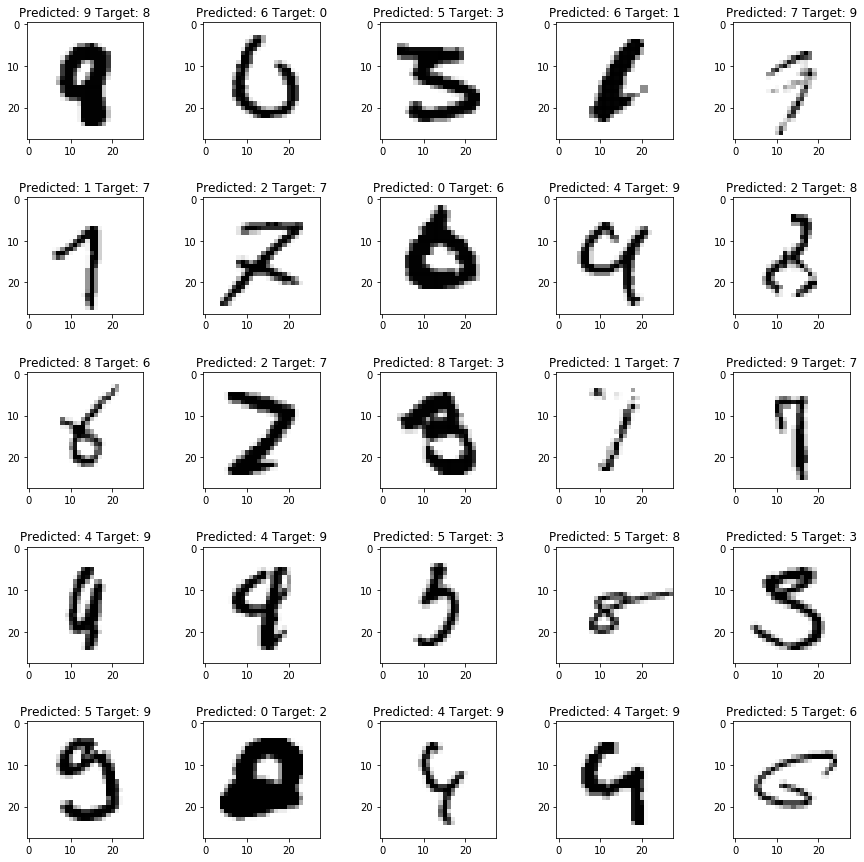

In [0]:
misclassified_images(misclassify)

In [0]:
train_acc_with_l1_l2 = train_acc.copy()
train_loss_with_l1_l2 = train_losses.copy()
test_acc_with_l1_l2 = test_acc.copy()
test_loss_with_l1_l2 = test_losses.copy()

Text(0.5, 1.0, 'Test Accuracy')

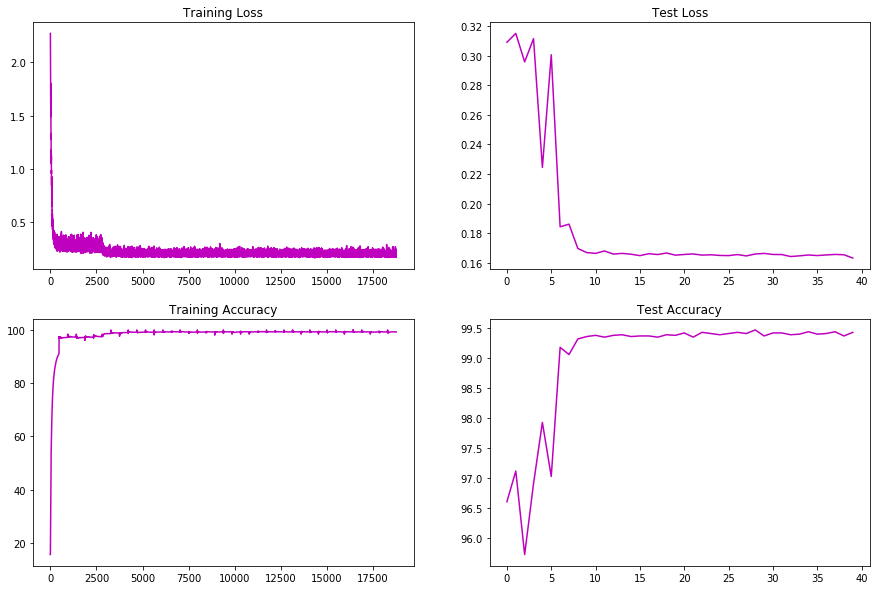

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_loss_with_l1_l2,color = 'm')

axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_with_l1_l2,color = 'm')

axs[1, 0].set_title("Training Accuracy")

axs[0, 1].plot(test_loss_with_l1_l2,color = 'm')

axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_with_l1_l2,color = 'm')

axs[1, 1].set_title("Test Accuracy")

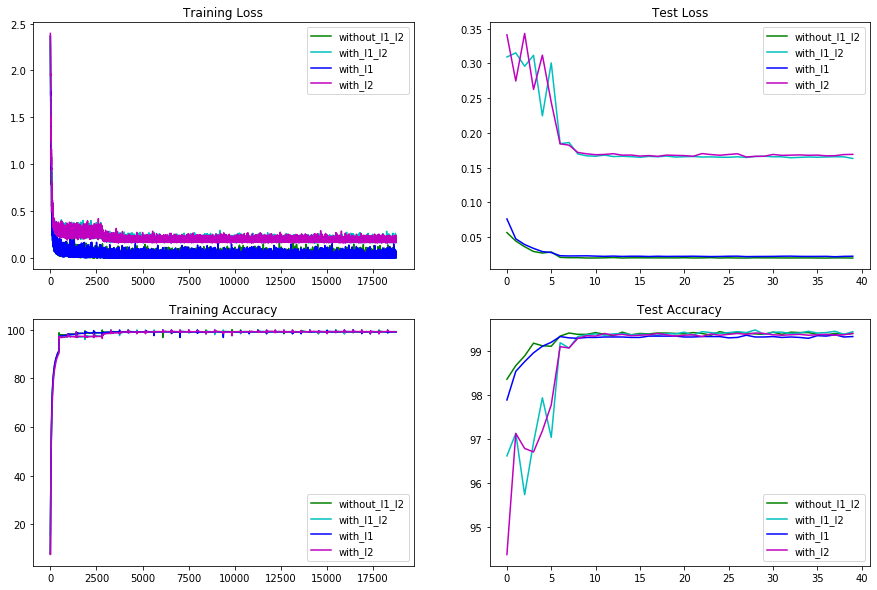

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_without_l1_l2,color = 'g',label="without_l1_l2")
axs[0, 0].plot(train_loss_with_l1_l2,color = 'c',label="with_l1_l2")
axs[0, 0].plot(train_loss_with_l1,color = 'b',label="with_l1")
axs[0, 0].plot(train_loss_with_l2,color = 'm',label="with_l2")
axs[0, 0].set_title("Training Loss")
axs[0, 0].legend()
axs[1, 0].plot(train_acc_without_l1_l2,color = 'g',label="without_l1_l2")
axs[1, 0].plot(train_acc_with_l1_l2,color = 'c',label="with_l1_l2")
axs[1, 0].plot(train_acc_with_l1,color = 'b',label="with_l1")
axs[1, 0].plot(train_acc_with_l2,color = 'm',label="with_l2")
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].legend()
axs[0, 1].plot(test_loss_without_l1_l2,color = 'g',label="without_l1_l2")
axs[0, 1].plot(test_loss_with_l1_l2,color = 'c',label="with_l1_l2")
axs[0, 1].plot(test_loss_with_l1,color = 'b',label="with_l1")
axs[0, 1].plot(test_loss_with_l2,color = 'm',label="with_l2")
axs[0, 1].set_title("Test Loss")
axs[0, 1].legend()
axs[1, 1].plot(test_acc_without_l1_l2,color = 'g',label="without_l1_l2")
axs[1, 1].plot(test_acc_with_l1_l2,color = 'c',label="with_l1_l2")
axs[1, 1].plot(test_acc_with_l1,color = 'b',label="with_l1")
axs[1, 1].plot(test_acc_with_l2,color = 'm',label="with_l2")
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].legend()

Text(0.5, 0.98, 'l1 = 0.0005, l2 = 0.05')

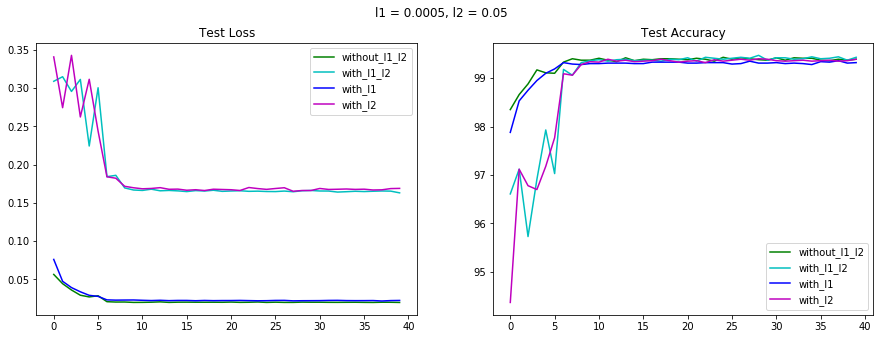

In [43]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(test_loss_without_l1_l2,color = 'g',label="without_l1_l2")
axs[0].plot(test_loss_with_l1_l2,color = 'c',label="with_l1_l2")
axs[0].plot(test_loss_with_l1,color = 'b',label="with_l1")
axs[0].plot(test_loss_with_l2,color = 'm',label="with_l2")
axs[0].set_title("Test Loss")
axs[0].legend()
axs[1].plot(test_acc_without_l1_l2,color = 'g',label="without_l1_l2")
axs[1].plot(test_acc_with_l1_l2,color = 'c',label="with_l1_l2")
axs[1].plot(test_acc_with_l1,color = 'b',label="with_l1")
axs[1].plot(test_acc_with_l2,color = 'm',label="with_l2")
axs[1].set_title("Test Accuracy")
axs[1].legend()
fig.suptitle("l1 = 0.0005, l2 = 0.05")